<a href="https://colab.research.google.com/github/zzyy-gh/nn-practice/blob/main/ai_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

Make sure the current session has the OQC.mat file, you can do so by uploading it through the left sidebar as shown below:
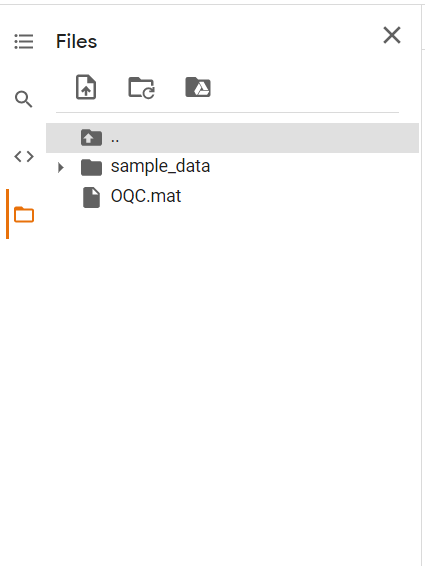



# Import Packages and Data

In [ ]:
# !pip install optuna

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from random import randint
import time
import matplotlib.pyplot as plt
# import optuna

In [ ]:
data = scipy.io.loadmat('OQC.mat')
data_extract = data['data']
df = pd.DataFrame(data_extract)
X = df.iloc[:,0:48]
Y = df.iloc[:,-1]

# print(data)
# print(data_extract)
# print(df)
# print(X)
# print(Y)

# Task 1

Functions and class

In [ ]:
class nn3(nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
    super(nn3, self).__init__()

    self.layer1=nn.Linear(input_size, hidden_size1, bias=True)
    self.layer2=nn.Linear(hidden_size1, hidden_size2, bias=True)
    self.layer3=nn.Linear(hidden_size2, output_size, bias=True)
  
  def Forward(self,x):
    x1=self.layer1(x)
    x2=F.relu(x1)
    x2=self.layer2(x2)
    x3=F.relu(x2)
    x3=self.layer3(x3)
    p=F.softmax(x3,dim=1)

    # return x3
    return p

def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    # print(num_matches)
    
    return 1-num_matches.float()/bs 

def eval_on_test_set_sgd(model):

    
    minibatch_X = torch.Tensor(X_test.values)
    minibatch_Y = torch.Tensor(np.array(Y_test.values)).long().view(len(X_test))

    scores=model.Forward( minibatch_X ) 
    # print(scores)

    error = get_error( scores , minibatch_Y)
    return error.item() * 100

Split train test set

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
# X_train
# Y_test
# X_train.iloc[[0,1,2]].values

Build NN

In [ ]:
net1 = nn3(48, 30, 30, 3)
# print(net1)
lr = 0.05
data_size = len(X_train)
feature_number = X_train.shape[-1]
bs = 50
epoch_size = 100
criterion = nn.NLLLoss()

for epoch in range(epoch_size):
  optimizer=torch.optim.SGD( net1.parameters() , lr=lr ) # new optimizer for each epoch
  
  running_loss=0
  running_error=0
  num_batches=0

  shuffled_indices= np.random.randint(0, data_size, data_size)
  
  for count in range(0, data_size, bs):
    optimizer.zero_grad() # reset gradient

    indices = shuffled_indices[count : count + bs]
    minibatch_X = torch.Tensor(X_train.iloc[indices].values)
    minibatch_Y = torch.Tensor(np.array(Y_train.iloc[indices].values)).long().view(len(indices))

    minibatch_X.requires_grad_()
    prob = torch.Tensor(net1.Forward(minibatch_X)).view(len(indices), 3)
    log_prob=torch.log(prob)

    loss = criterion(log_prob, minibatch_Y)
    optimizer.zero_grad()       
    loss.backward()
    optimizer.step()

    # compute some stats
    
    running_loss += loss.detach().item()
            
    error = get_error( log_prob.detach() , minibatch_Y)
    running_error += error.item()
    
    num_batches+=1

  # once the epoch is finished we divide the "running quantities"
  # by the number of batches
  
  total_loss = running_loss/num_batches
  total_error = running_error/num_batches
  
  # every 10 epoch we display the stats 
  # and compute the error rate on the test set  
  
  if epoch % 10 == 0 : 
  
      print(' ')      
      print('epoch=',epoch,
            ' loss=', total_loss , ' error=', total_error*100 ,'percent lr=', lr)
      
      eval_on_test_set_sgd(net1)
      

nn3(
  (layer1): Linear(in_features=48, out_features=30, bias=True)
  (layer2): Linear(in_features=30, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=3, bias=True)
)
 
epoch= 0  loss= 1.1005036320005144  error= 67.94047611100333 percent lr= 0.05
test error  =  tensor(63.3183) percent
 
epoch= 10  loss= 0.37979120370887576  error= 13.321429065295629 percent lr= 0.05
test error  =  tensor(47.5169) percent
 
epoch= 20  loss= 0.20133891985529945  error= 8.047619603929066 percent lr= 0.05
test error  =  tensor(5.7562) percent
 
epoch= 30  loss= 0.09737160034655105  error= 2.904761689049857 percent lr= 0.05
test error  =  tensor(7.5621) percent
 
epoch= 40  loss= 0.04227762740282785  error= 0.6190473125094459 percent lr= 0.05
test error  =  tensor(2.3702) percent
 
epoch= 50  loss= 0.02697915943073375  error= 0.1428570066179548 percent lr= 0.05
test error  =  tensor(0.6772) percent
 
epoch= 60  loss= 0.0211500294196109  error= 0.2857144389833723 percent lr= 0.05


Checking

In [ ]:
# input=torch.Tensor(X_test.iloc[2,:])
# prob = torch.Tensor(net1.Forward(input)).view(1, 3) 
# print(prob)
# print(Y_test.iloc[2])
# torch.argmax(prob) == Y_test.iloc[222]
# get_error(prob, Y_test.iloc[222])

NN 2-in-1 Builder & Trainer

In [ ]:
def nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, output_size, lr, epoch_size, bs, data_size_per_epoch):
  start = time.time()
  results = []
  # custom nn class
  class nnN(nn.Module):
    def __init__(self, input_size, layer_size_dis, output_size):
      super(nnN, self).__init__()
      self.layers = nn.ModuleList()
      self.lsd_len = len(layer_size_dis) 
      if self.lsd_len == 0:
        self.layers.append(nn.Linear(input_size, output_size, bias=True))
      else:
        self.layers.append(nn.Linear(input_size, layer_size_dis[0], bias=True))
        for i in range(1,self.lsd_len):
          self.layers.append(nn.Linear(layer_size_dis[i-1], layer_size_dis[i], bias=True))
        self.layers.append(nn.Linear(layer_size_dis[self.lsd_len-1], output_size, bias=True))

    
    def Forward(self,x):
      x=self.layers[0](x)
      for i in range(1, self.lsd_len + 1):
        x=F.relu(x)
        x=self.layers[i](x)
      p=F.softmax(x,dim=1)

      # return x3
      return p

  data_size = len(X_train)
  feature_number = X_train.shape[-1]
  criterion = nn.NLLLoss()
  net = nnN(feature_number, layer_size_dis, output_size)
  # print(net)

  for epoch in range(epoch_size):
    optimizer=torch.optim.SGD( list(net.parameters()) , lr=lr ) # new optimizer for each epoch
    # print(list(net.parameters()))
    # print("1")

    running_loss=0
    running_error=0
    num_batches=0

    shuffled_indices= np.random.randint(0, data_size, data_size)
    # print("1")
    
    for count in range(0, data_size_per_epoch, bs):
      # print("1") 
      optimizer.zero_grad() # reset gradient

      indices = shuffled_indices[count : count + bs]
      # print("1")
      minibatch_X = torch.Tensor(X_train.iloc[indices].values)
      minibatch_Y = torch.Tensor(np.array(Y_train.iloc[indices].values)).long().view(len(indices))
      # print("1")
      minibatch_X.requires_grad_()
      # print("1")
      prob = torch.Tensor(net.Forward(minibatch_X)).view(len(indices), output_size)
      # print("1")
      log_prob=torch.log(prob)
      # print("1") 
      loss = criterion(log_prob, minibatch_Y)
      optimizer.zero_grad()       
      loss.backward()
      optimizer.step()

      # compute some stats
      
      running_loss += loss.detach().item()
              
      error = get_error( log_prob.detach() , minibatch_Y)
      running_error += error.item()
      
      num_batches+=1
      # print("1") 


    # once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches*100
    total_error = running_error/num_batches*100
    
    # every 10 epoch we display the stats 
    # and compute the error rate on the test set 
    
    if epoch % 5 == 0 or epoch == epoch_size - 1: 
      test_error = eval_on_test_set_sgd(net)
      results.append({
          'epoch': epoch,
          'loss': total_loss,
          'error(%)': total_error,
          'test_error(%)': test_error
      })
      # print(' ')      
      # print('epoch=',epoch,
      #       ' loss=', total_loss , ' error=', total_error*100 ,'percent lr=', lr)
      
      # print( 'test error  = ', test_error ,'percent')
  elapsed_time = time.time() - start
  hyperparams = {
      'hidden_layers': layer_size_dis,
      'learning_rate': lr,
      'epoch_size': epoch_size,
      'batch_size': bs,
      'elapsed_time': elapsed_time
  }
  
  # print(pd.DataFrame.from_dict([hyperparams]))
  # print(' ')
  # print(pd.DataFrame.from_dict(results))
  # print(' ')
  # print('elapsed time: ', elapsed_time, "s")
  return results, hyperparams


In [ ]:
for i in range(1):
  # layer_size_dis, lr, epoch_size, bs = [30, 30], 0.05, 100, 50
  # layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
  layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
  nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))

# Task 2: Network


Deep network

In [ ]:
for i in range(1):
  layer_size_dis, lr, epoch_size, bs = [30, 30, 30, 30, 30, 30, 30, 30], 0.05, 200, 50
  # layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
  # layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
  resultsDp, hyperparamsDp = nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))
  # print(pd.DataFrame.from_dict([hyperparamsDp]))
  # print(' ')
  # print(pd.DataFrame.from_dict(resultsDp))
  # print(' ')
  # print('elapsed time: ', elapsed_timeDp, "s")

Shallow Network

In [ ]:
for i in range(1):
  layer_size_dis, lr, epoch_size, bs = [30, 30], 0.05, 200, 50
  # layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
  # layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
  resultsSh, hyperparamsSh = nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))
  

Narrow Network

In [ ]:
for i in range(1):
  layer_size_dis, lr, epoch_size, bs = [5, 5], 0.05, 200, 50
  # layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
  # layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
  resultsNr, hyperparamsNr = nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))

Wide network

In [ ]:
for i in range(1):
  layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 200, 50
  # layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
  # layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
  resultsWd, hyperparamsWd = nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))

Analysis

   learning_rate  batch_size
0           0.05          50
 
                      hidden_layers  elapsed_time
0  [30, 30, 30, 30, 30, 30, 30, 30]     17.040019
1                          [30, 30]     10.802966
2                            [5, 5]     10.708464
3                        [100, 100]     11.855043
 


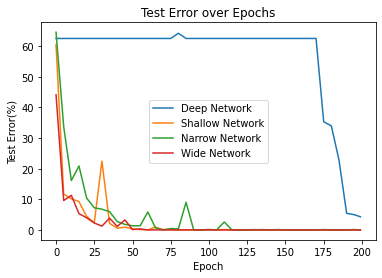

In [ ]:
print(pd.DataFrame.from_dict([hyperparamsDp])[['learning_rate', 'batch_size']])
print(" ")
print(pd.DataFrame([hyperparamsDp, hyperparamsSh, hyperparamsNr, hyperparamsWd])[['hidden_layers', 'elapsed_time']])
print(" ")
plt.plot([d['epoch'] for d in resultsDp], [d['test_error(%)'] for d in resultsDp], label = "Deep Network")
plt.plot([d['epoch'] for d in resultsSh], [d['test_error(%)'] for d in resultsSh], label = "Shallow Network")
plt.plot([d['epoch'] for d in resultsNr], [d['test_error(%)'] for d in resultsNr], label = "Narrow Network")
plt.plot([d['epoch'] for d in resultsWd], [d['test_error(%)'] for d in resultsWd], label = "Wide Network")
# naming the x axis
plt.xlabel('Epoch')
# naming the y axis
plt.ylabel('Test Error(%)')
# giving a title to my graph
plt.title('Test Error over Epochs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

# Task 3: Learning Rate


In [ ]:
lrs = [0.001, 0.01, 0.1, 0.5]
results = {}
hyperparams = {}
for lr in lrs:
  layer_size_dis, lr, epoch_size, bs = [30, 30], lr, 250, 50
  # layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
  # layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
  results[str(lr)], hyperparams[str(lr)] = nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))

Analysis

  hidden_layers  batch_size
0      [30, 30]          50
 
   learning_rate  elapsed_time
0          0.001     13.816473
1          0.010     13.692353
2          0.100     13.896538
3          0.500     13.603604
 


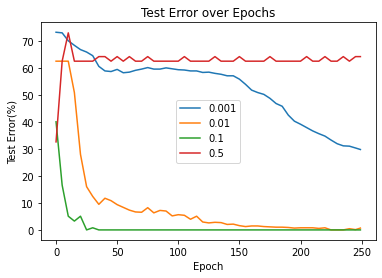

In [ ]:
print(pd.DataFrame.from_dict([hyperparams['0.001']])[['hidden_layers', 'batch_size']])
print(" ")
print(pd.DataFrame(hyperparams.values())[['learning_rate', 'elapsed_time']])
print(" ")
for lr in lrs:
  plt.plot([d['epoch'] for d in results[str(lr)]], [d['test_error(%)'] for d in results[str(lr)]], label = str(lr))

# naming the x axis
plt.xlabel('Epoch')
# naming the y axis
plt.ylabel('Test Error(%)')
# giving a title to my graph
plt.title('Test Error over Epochs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

# Task 4


BS = 1

In [ ]:
layer_size_dis, lr, epoch_size, bs = [30, 30], 0.05, 100, 1
# layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
# layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
results1, hyperparams1 = nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))

BS = 50

In [ ]:
layer_size_dis, lr, epoch_size, bs = [30, 30], 0.05, 100, 50
# layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
# layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
results50, hyperparams50 = nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))

BS = 500

In [ ]:
layer_size_dis, lr, epoch_size, bs = [30, 30], 0.05, 500, 500
# layer_size_dis, lr, epoch_size, bs = [100, 100], 0.05, 100, 50
# layer_size_dis, lr, epoch_size, bs = [30, 30], 0.5, 100, 50
results500, hyperparams500 = nnBuilder(X_train, X_test, Y_train, Y_test, layer_size_dis, 3, lr, epoch_size, bs, len(X_train))

Analysis

   learning_rate hidden_layers
0           0.05      [30, 30]
 
   batch_size  elapsed_time
0           1    265.744013
1          50      7.813396
2         500      4.775279
 


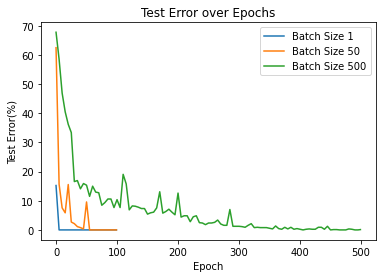

In [ ]:
print(pd.DataFrame.from_dict([hyperparams500])[['learning_rate', 'hidden_layers']])
print(" ")
print(pd.DataFrame([hyperparams1, hyperparams50, hyperparams500])[['batch_size', 'elapsed_time']])
print(" ")
plt.plot([d['epoch'] for d in results1], [d['test_error(%)'] for d in results1], label = "Batch Size 1")
plt.plot([d['epoch'] for d in results50], [d['test_error(%)'] for d in results50], label = "Batch Size 50")
plt.plot([d['epoch'] for d in results500], [d['test_error(%)'] for d in results500], label = "Batch Size 500")

# naming the x axis
plt.xlabel('Epoch')
# naming the y axis
plt.ylabel('Test Error(%)')
# giving a title to my graph
plt.title('Test Error over Epochs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()